In [2]:
import matplotlib.pyplot as plt
from ptoa.data.fastmri_dataset import FastSliceDataset
import pandas as pd
import numpy as np
from pathlib import Path
from models.network import Network
import torch
from glob import glob
from torch import nn
from PIL import Image
import torchvision.transforms as T
from tqdm import tqdm

In [15]:
l1 = nn.L1Loss()
l2 = nn.MSELoss()
tx = T.ToTensor()
SMOOTH = 10

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


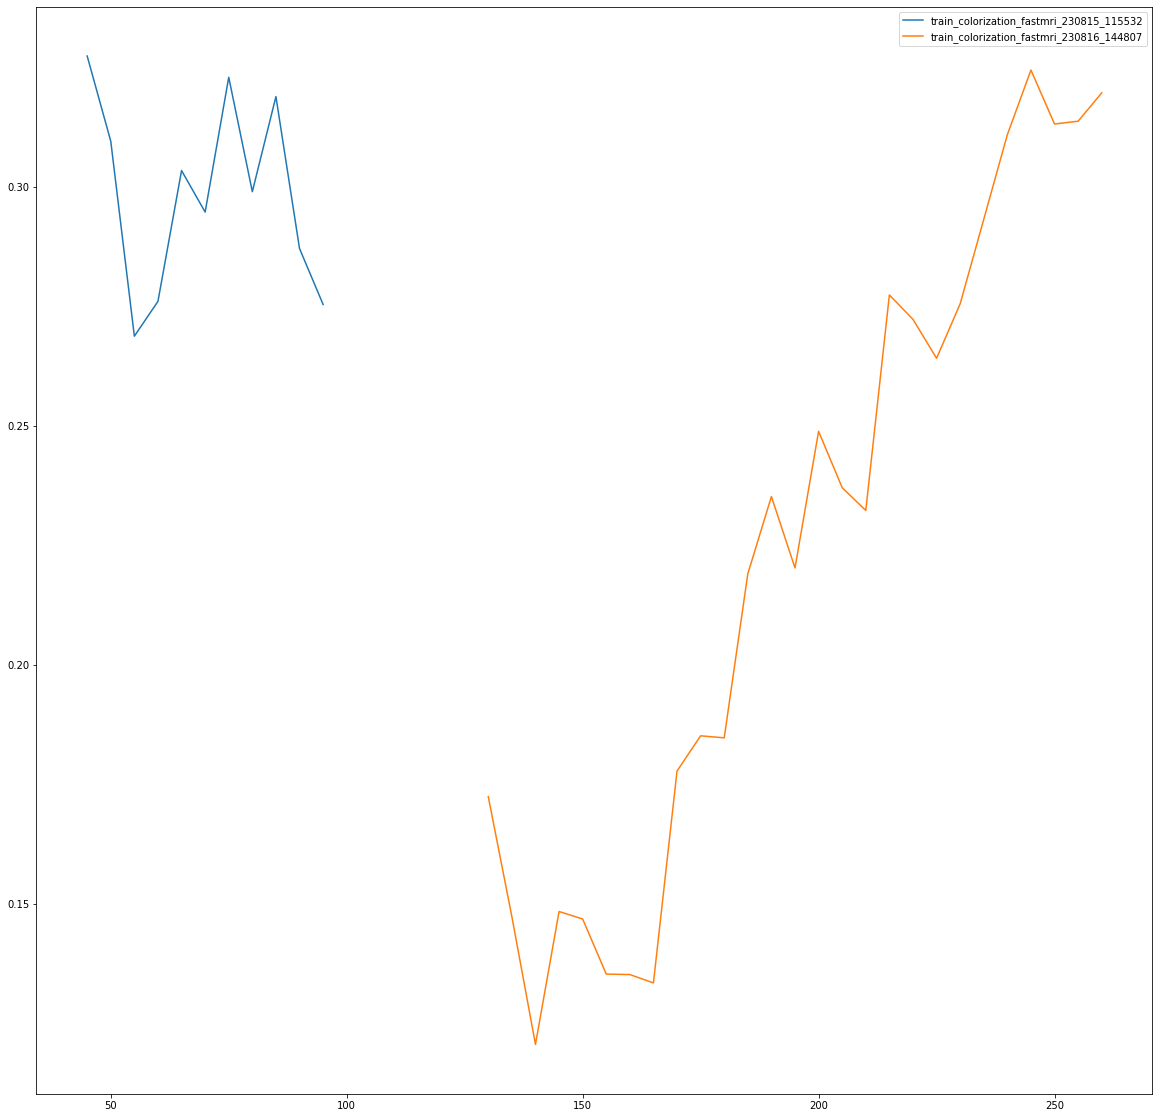

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*colorization*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=0):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0]} for k in slcs}
        l1_loss = []
        l2_loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            l1_loss.append(l1(out_array, gt_array))
            l2_loss.append(l2(out_array, gt_array))
        ret[epoch] = {
            'l1_loss': torch.tensor(l1_loss).mean(),
            'l2_loss': torch.tensor(l2_loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    ax.plot(ret.keys(), pd.Series([r['l1_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)
    # plt.plot(ret.keys(), [r['l2_loss'] for r in ret.values()], label='l2_loss')
    # plt.title(experiment)
ax.legend()
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:15<00:00,  2.16s/it]


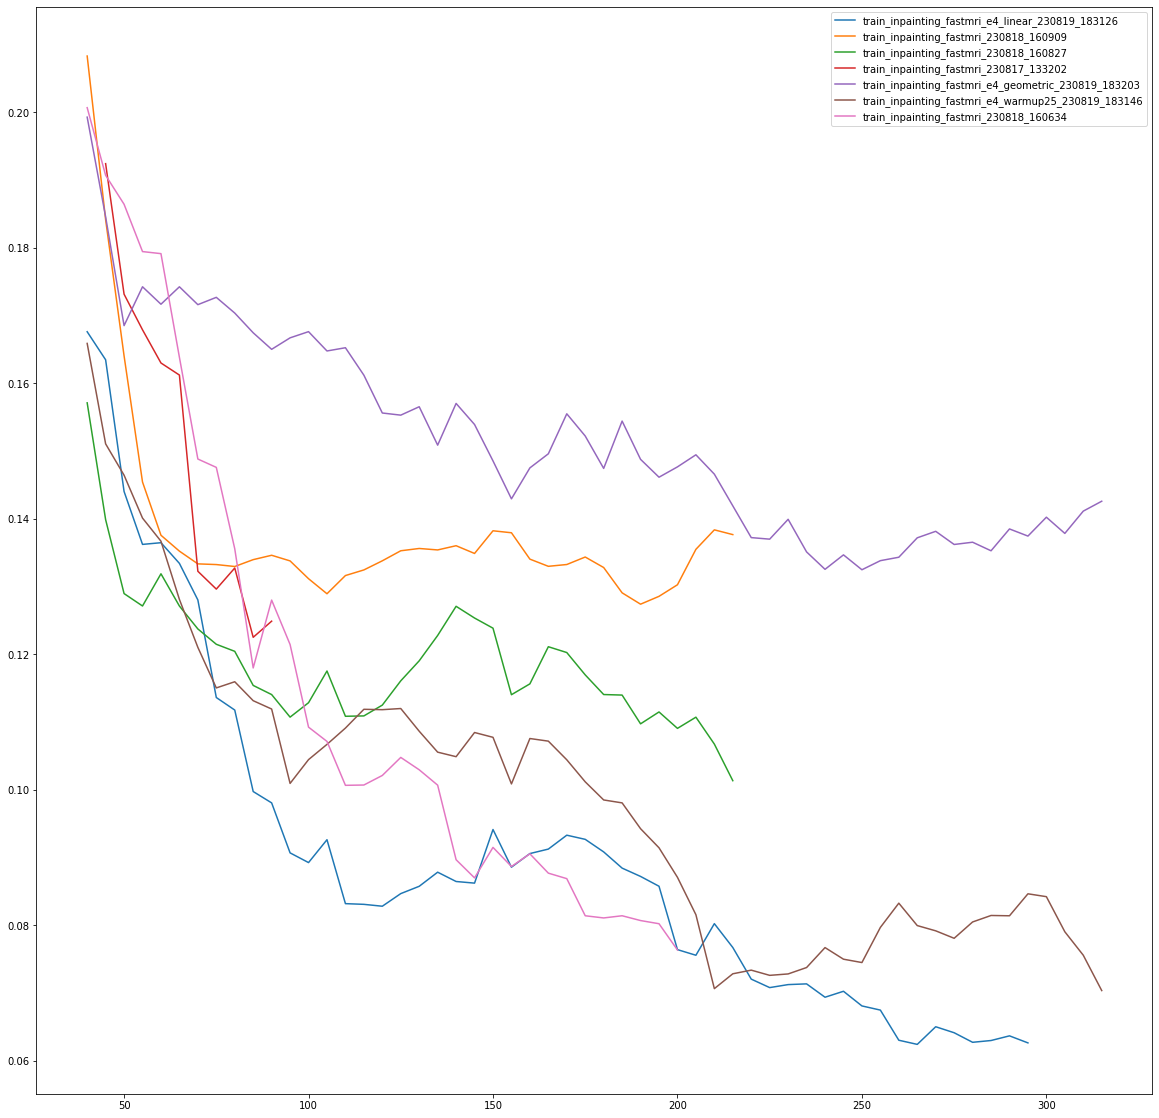

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
for ROOT in tqdm(glob('experiments/*inpainting*'), position=0):
    ROOT = ROOT + '/results/val/'
    experiment = ROOT.split('/')[-4]
    folders = glob(f"{ROOT}/*")
    folders = sorted(folders, key=lambda f: int(f.split('/')[-1]))
    ret = {}
    for folder in tqdm(folders, position=1):
        epoch = int(folder.split('/')[-1])
        pngs = [g for g in glob(f'{folder}/*') if any(x in g for x in ['GT', 'Out', 'Mask'])]
        slcs = set([p.split('/')[-1].replace('GT_','').replace('Out_','').replace('Mask_','') for p in pngs])
        slcs = {k:
            {'gt': [p for p in pngs if k in p and 'GT' in p][0],
            'out': [p for p in pngs if k in p and 'Out' in p][0],
            'mask': [p for p in pngs if k in p and 'Mask' in p][0]} for k in slcs}
        masked_loss = []
        loss = []
        for slc in slcs.values():
            gt_path = slc['gt']
            gt = Image.open(gt_path)
            gt_array = tx(gt)
            out_path = slc['out']
            out = Image.open(out_path)
            out_array = tx(out)
            mask_path = slc['mask']
            mask = Image.open(mask_path)
            mask_array = tx(mask) == 1
            masked_loss.append(torch.sum(torch.abs(gt_array - out_array)) / mask_array.sum())
            loss.append(l1(out_array, gt_array))
        ret[epoch] = {
            'masked_loss': torch.tensor(masked_loss).mean(),
            'loss': torch.tensor(loss).mean(),
        }
        # print(experiment, epoch, end='\r')

    ax.plot(ret.keys(), pd.Series([r['masked_loss'] for r in ret.values()]).rolling(window=SMOOTH).mean(), label=experiment)
    # plt.plot(ret.keys(), [r['loss'] for r in ret.values()], label='masked_loss')
ax.legend()
plt.show()